# Model Selection Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD

import os
import sys
sys.path.append("..")

from modules.filters.rule_based import RuleBasedFiltering
from modules.filters.content_based import ContentBasedFiltering
from modules.filters.collaborative import CollaborativeFiltering
from app import load_dataset, partition_data

In [2]:
# Gloal variables
STORAGE_DIR = '../storage/'

# Source Data Paths
ratings_data_path = os.path.join(STORAGE_DIR, 'u.data')
item_data_path = os.path.join(STORAGE_DIR, 'u.item') 
user_data_path = os.path.join(STORAGE_DIR, 'u.user')
genre_data_path = os.path.join(STORAGE_DIR, 'u.genre')
occupation_data_path = os.path.join(STORAGE_DIR, 'u.occupation')

# Data Partition Paths
train_data_path = os.path.join(STORAGE_DIR, 'train')
test_data_path = os.path.join(STORAGE_DIR, 'test')

### Task 3: Model Selection Analysis (50pts)

Create a notebook notebooks/model_selection.ipynb to compare model performance on the full dataset. The notebook must:

* Train each model using a valid partitioned dataset
    * In a markdown cell, explicitly describe you partitioning strategy and explain why your strategy is valid.
* Evaluate each model using RMSE/MAE, and nDCG on a test set (See Task 1 to load and partition the dataset).
* Visualize performance comparisons and an explanation of the results.
    * In a markdown cell, explain how your results would impact your design decisions.
* Detail how your observations would influence your design.

In [3]:
# Load Dataset
ratings = load_dataset(ratings_data_path, separation_type="\t")
ratings.columns = ["user", "item", "rating", "timestamp"]
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

print(f"Dataset shape: {ratings.shape}")
display(ratings.head())

Dataset shape: (100000, 4)


,user,item,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


#### Data Partitioning Strategy

Here **temporal data partitioning** will be adopted to simulates the real-world recommendation setting - predicting future user behavior based on past behavior.

* **Rule-Based Filtering**: A temporal split allows us to assess the longevity and predictive power of our rules. For instance, we can determine if the most popular items in the past (training set) are still popular in the future (test set).
* **Content-Based Filtering**: This split directly evaluates the core function of a content-based system: its ability to predict a user's future interests based on their past content consumption.
* **Collaborative Filtering**: This split accurately simulates a production environment where the model is trained on historical data and must predict future user-item interactions.

Given that, using user-based split may encounter problems as below:
* **Rule-Based Filtering**: The performance of simple rule-based systems (i.e., "recommend the top-rating items") is not user-specific. A user-based split doesn't effectively test the rule itself.
* **Content-Based Filtering**: This model requires a user's interaction history to build a profile and make recommendations. If a user is entirely in the test set, there is no data to build a profile from, making personalized recommendations impossible.
* **Collaborative Filtering**: Collaborative model needs a user's past interactions to find similar users. A user in the test set with no prior history in the training data cannot be given personalized recommendations

(However, the user-based spliting could be beneficial if the goal is to test the "cold start" problem - a strict user-based split ensures the test users are entirely "cold", which allows us to measure how well the system handles the initial interactions, which is not the hypothetical goal of this study)

In [4]:
# Partition Data by temporal split
train_df, test_df = partition_data(ratings, split=.5, partition_type='temporal')
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

print(f"Timestamp range in original dataset: {ratings['timestamp'].min()} to {ratings['timestamp'].max()}")
print(f"Timestamp range in train dataset: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"Timestamp range in test dataset: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

Train dataset shape: (50000, 4)
Test dataset shape: (50000, 4)
Timestamp range in original dataset: 1997-09-20 03:05:10 to 1998-04-22 23:10:38
Timestamp range in train dataset: 1997-09-20 03:05:10 to 1997-12-22 21:42:24
Timestamp range in test dataset: 1997-12-22 21:42:24 to 1998-04-22 23:10:38


#### Cold Start vs Warm Start

In [5]:
# Check for cold-start users/items 
# Users/items in training set
train_users = set(train_df['user'].unique())
train_items = set(train_df['item'].unique())

# Users/items in test set
test_users = set(test_df['user'].unique())
test_items = set(test_df['item'].unique())

# Cold-start users/items
cold_users = test_users - train_users
cold_items = test_items - train_items

print(f"Cold-start users: {len(cold_users)}")
print(f"Cold-start items: {len(cold_items)}")

Cold-start users: 452
Cold-start items: 216


There are users and items in test set that do not appear in the train set. Those are cold-start entries that would affect model performance in the following aspects.

* **Rule-based Filtering**: This model will be not affected by cold-start cases as it's not a personalized recommendation. Actually, many rule-based systems are specifically designed for the cold-start problem. 

* **Content-based Filtering**: This model cannot personalize well without any interaction history to build a user profile. However, it can reecommend new items easily as long as item features are available — because recommendations rely on matching item attributes to the user’s existing profile. That is, the CBF cannot address cold-start user cases but works well with cold-start items - as long as they come with corresponding metadata.

* **Collaborative Filtering**: Its primary drawback is the inability to handle new users or items. That is, it cannot predict well for either cold-start users or items.


Since the models differ in their ability to handle cold-start cases, this test will exclude cold-start entries to ensure a fair comparison of their core recommendation logic.

With that, the targeted question in this test is: **"For the users and items we already know, how well the models predict future positive interactions?"** 

This allows us measure performance on the core, engaged user base, which can be critical to the business in the real world -- to increase engagement and satisfaction among the users you already have with the products you already carry.

In [6]:
# Remove cold-start entries from test set
test_df = test_df[
    test_df['user'].isin(train_users) & test_df['item'].isin(train_items)
]
print(f"Filtered test dataset shape: {test_df.shape}")

Filtered test dataset shape: (5995, 4)


In [7]:
# Save the train and test datasets
train_df.to_csv(train_data_path, sep='\t', header=False, index=False)
test_df.to_csv(test_data_path, sep='\t', header=False, index=False)

#### Performance Evaluation 
* Evaluate each model using RMSE/MAE, and nDCG on the test set.
* Visualize performance comparisons and an explanation of the results.

In [8]:
genre_df = pd.read_csv(genre_data_path, sep='|', header=None, names=['genre', 'id'])
occupation_df = pd.read_csv(occupation_data_path, sep='|', header=None, names=['occupation'])

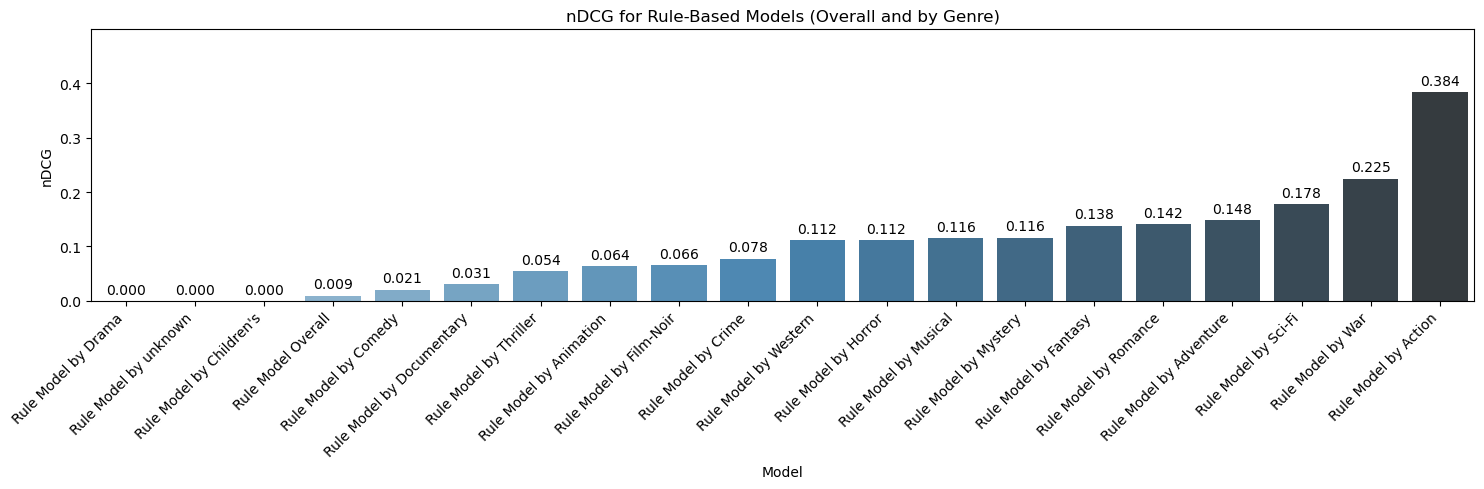

In [9]:
# Rule-based filtering
rule_model = RuleBasedFiltering(train_data_path, item_data_path, user_data_path) 
recommend_overall = rule_model.recommend(k=5, rule='overall')

performance = []
performance.append({
    'Model': 'Rule Model Overall',
    'Metric': 'nDCG',
    'Value': rule_model.evaluate(recommend_overall, test_df)
})

# Recommend top-rated movies by genre
for genre in genre_df['genre'].tolist():
    recommend_genre = rule_model.recommend(k=5, rule='by_genre', criteria=genre)  
    performance.append({
        'Model': f'Rule Model by {genre}',
        'Metric': 'nDCG',
        'Value': rule_model.evaluate(recommend_genre, test_df)
    })

# Visualize the performance
ndcg_df = pd.DataFrame(performance).sort_values(by='Value', ascending=True)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=ndcg_df, x='Model', y='Value', hue='Model', palette='Blues_d')

plt.title("nDCG for Rule-Based Models (Overall and by Genre)")
plt.ylabel("nDCG")
plt.ylim(0, max(ndcg_df['Value'].max() * 1.3, 0.05))
plt.xticks(rotation=45, ha='right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3) # Add labels with formatting and padding

plt.tight_layout()
plt.show()

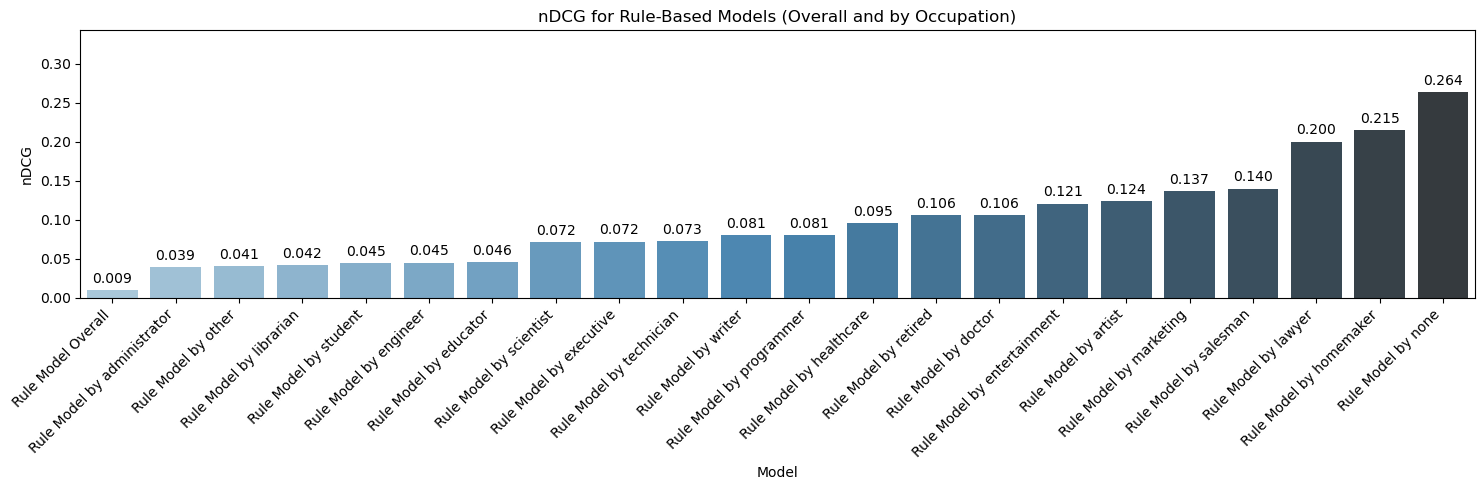

In [10]:
performance = []
performance.append({
    'Model': 'Rule Model Overall',
    'Metric': 'nDCG',
    'Value': rule_model.evaluate(recommend_overall, test_df)
})

# Recommend top-rated movies by occupation
for occupation in occupation_df['occupation'].tolist():
    recommend_occupation = rule_model.recommend(k=5, rule='by_occupation', criteria=occupation)  # top-rated movies by occupation
    performance.append({
        'Model': f'Rule Model by {occupation}',
        'Metric': 'nDCG',
        'Value': rule_model.evaluate(recommend_occupation, test_df)
    })

# Visualize the performance
ndcg_df = pd.DataFrame(performance).sort_values(by='Value', ascending=True)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=ndcg_df, x='Model', y='Value', hue='Model', palette='Blues_d')

plt.title("nDCG for Rule-Based Models (Overall and by Occupation)")
plt.ylabel("nDCG")
plt.ylim(0, max(ndcg_df['Value'].max() * 1.3, 0.05))
plt.xticks(rotation=45, ha='right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3) # Add labels with formatting and padding

plt.tight_layout()
plt.show()

#### Performance Analysis (Part I)
**Rule-based Filtering**  
* Most rule-based recommendations yield extremely low nDCG scores (< 0.28, closer to 0 than to 1), which implies: the items being recommended are not matching the user's preferences or past interactions, even in top ranks.
* The genre-filtered version (by_Action) performs the best (nDCG = 0.384) — suggesting domain-aware rule models might help.
* All the rule-based systems are non-personalized, which explains low performance in personalized ranking metrics like nDCG.

In [11]:
# Content-based Filtering
content_model = ContentBasedFiltering(train_data_path, item_data_path)

# Collaborative Filtering
svd_params = {'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}
collaborative_model = CollaborativeFiltering(
    ratings_data_path, 
    item_data_path, 
    SVD(**svd_params),
    trainset_df=train_df,
    validset_df=test_df)
collaborative_model.fit()

# Evaluation for predictive models
performance = []
performance.append({
    'Model': 'Content-based Model',
    'Metric': 'RMSE',
    'Value': content_model.evaluate(validset_df=test_df)
})

performance.append({
    'Model': 'Collaborative Model',
    'Metric': 'RMSE',
    'Value': collaborative_model.evaluate()
})

for perf in performance:
    print(f"{perf['Metric']} for {perf['Model']}: {round(perf['Value'], 3)}")

RMSE for Content-based Model: 2.005
RMSE for Collaborative Model: 1.028


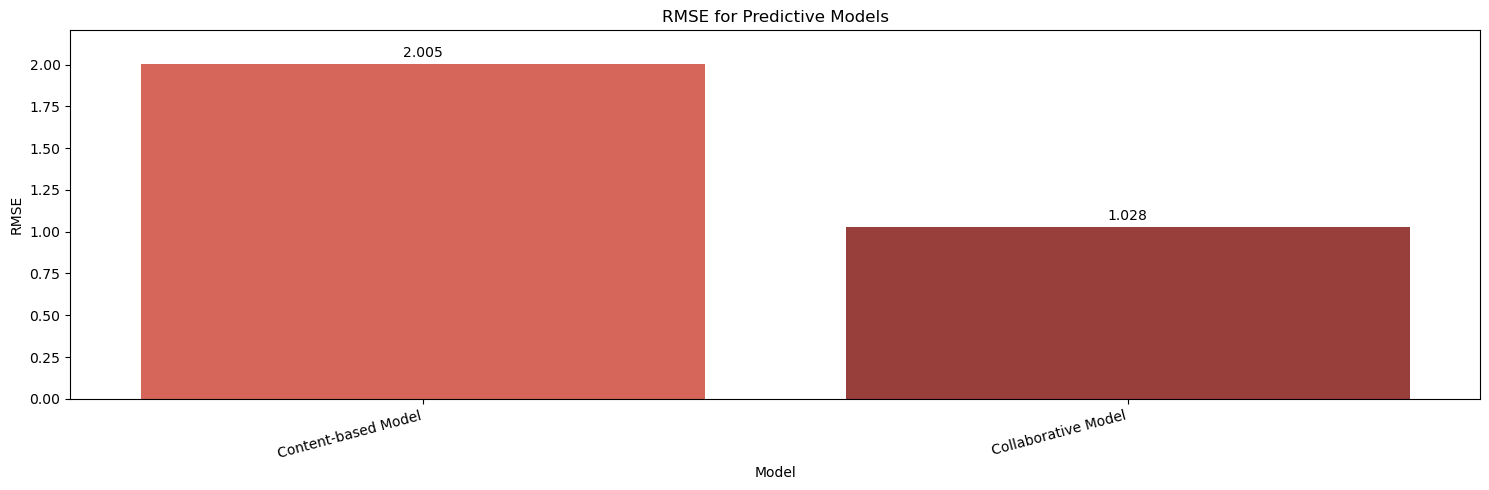

In [13]:
# Visualize
rmse_df = pd.DataFrame(performance)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=rmse_df, x='Model', y='Value', hue='Model', palette='Reds_d')

plt.title("RMSE for Predictive Models")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_df['Value'].max() * 1.1, 2.2))
plt.xticks(rotation=15, ha='right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3) # Add labels with formatting and padding

plt.tight_layout()
plt.show()


#### Performance Analysis (Part II)

* **Content-based Filtering** (RMSE = 2.01)
    * This shows moderate prediction accuracy.
    * RMSE ~2 on a 1–5 rating scale means predictions deviate from ground truth by about ±2 stars on average — not very accurate.
    * The possible reasons could be:
        * Sparse or low-quality user profiles
        * Weak item representations - in this case we have 'genre' as a single dimension for movies, which can be a very limited feature for accurate prediction.

* **Collaborative Filtering** (RMSE = 1.03)
    * This is a significantly better RMSE, suggesting the model is much better at predicting user-specific preferences.
    * Collaborative filtering uses actual user behavior, so it's naturally more effective for personalized recommendations when user history is available.
    * Particularly, the cold-start cases are excluded from this test, which is known as a common chanllenge for CF, and thus the performance is expected to be lifted from scenarios where cold-start entries are hybrized.

#### System Design Decisions
* **Rule-based Filtering**
    * Do not use rule-based models for **personalized recommendations**, as they (especially the overall one) rarely overlap with what the user actually interacted with or rated highly.
    * Instead:
        * It can be used for cold-start users and items, as only item metadata is needed.
        * Incoporating user/item segments (e.g. genre, recency, etc) would help increase contextual relevance.
* **Content-based Filtering**:  
    * The content features may be sparse or non-impactful to user's preferences.
    * It suffers from cold-start users.
    * Instead
        * It can be used for users/items with limited history, as it relies on the item metadata for recommendation.
        * Enriching item metadata (e.g. director, actors, release_date, plot summary, etc) can help identify similar items for better recommendation.
* **Collaborative Filtering**:
    * It provides strong foundation for primary recommendation engine — as long as the user has interaction history.

**Summary**
* Collaborative Filtering can be used as the main ranking engine
* For users and items with limited history; or cold-start users, back off to content-based filters
* For cold-start cases, apply rule-based filters
